# Explainable Networks

> What do you call it if someone has absolute faith in artificial intelligence?  - [Naive bias](https://en.m.wikipedia.org/wiki/Naive_Bayes_classifier).


Neural network models have acquired a reputation for being **black boxes** - they make accurate decisions, but we have a hard time explaining what actually influenced the decisions.  This can be an obstacle to the deployment of such models, when its decisions need to be transparent to enable technical, ethical or legal review. The field of **explainable artificial intelligence** aims to remedy this problem. In the following we are going to look at an algorithm that aims to explain predictions in image classification.

## Training Clever Hans

But first let me tell you the story of **Clever Hans**: _Der Kluge Hans_ was a trained horse that made headlines in Germany 1904 due to his amazing intelligence. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/Osten_und_Hans.jpg/640px-Osten_und_Hans.jpg)

During demonstrations, Hans was seemingly able to count and perform arithmetic exercises and answered correctly to the questions of the trainer, a mathematics teacher, by tapping his hooves or shaking his head. Scientists were puzzled. Eventually, a student solved the mystery: He was able to demonstrate that Clever Hans had no concept of mathematics, but was able to pick up on very subtle cues in the body language of the human posing the task. That allowed Hans to detect the right answer for about 90% of the questions.

Ever since then, research in animal cognition is wary of the **Clever Hans effect**, where the animal trainer unwittingly provides cues that are correlated with the right answer.  A similar phenomenon can happen when training machine learning systems:  Rather than learning a generalizable concept, the machine learning model is trained to pick up on _spurious correlations_ of the input data with the correct answer. [Ribeiro et al. ]() provide a practical example for this: An image classifier mislabels a picture of a husky as a wolf, even though the classifier was shown to have high accuracy during model engineering. Using the LIME algorithm - which we will introduce shortly - the authors are able to show the spurious correlation that the model used: Apparently the training images for "wolf" had snow in them.

![](graphics/husky-wolf.png)


This is related to the problem of **leakage** - _leaking_ the label to the classifier, allowing it to cheat. Leakage can be difficult to detect and requires careful cleaning of the data to avoid. A classifier performance that is "too good to be true" is often a sign of leakage. 

How can we gain more certainty about what the ML model reacts to? An analysis of [📓Feature Importance](../ml/ml-feature-engineering.ipynb) can give us insights. Inspecting deep learning models with very high-dimensional inputs is more challenging, but there are algorithmic approaches that can help.


## Preamble

In [1]:
from tensorflow import keras
import numpy
import matplotlib.pyplot as plt
import pandas

## Example Model: Inception V3 for Image Classification

[Inception V3](https://keras.io/applications/#inceptionv3) is a deep convolutional neural network architecture for image classification. A model trained on 1000 classes from the [ImageNet](ImageNet) benchmark data set is provided with `keras`.

In [2]:
from tensorflow.keras.applications import inception_v3

In [3]:
inception_model = inception_v3.InceptionV3()

Let's see how the Inception network classifies several animal photos. We need to do some preprocessing to get them into the right shape.

In [4]:
image_paths = {
    "dog" : "../.assets/data/xai_images/dog.10.jpg",
    "wolf 1":  "../.assets/data/xai_images/wolves-at-play.jpg",
    "dog guitar": "../.assets/data/xai_images/dog-guitar.jpg",
}

In [5]:
def preprocess_image(img_path):
    """Preprocess the """
    img = keras.preprocessing.image.load_img(
        img_path, 
        target_size=(299, 299)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    #img_array = numpy.expand_dims(img_array, axis=0)
    img_array = inception_v3.preprocess_input(img_array)
    img_array = img_array / 2 + 0.5  # brighten
    return img_array

In [6]:
images = dict(
    (key, preprocess_image(img_path))
              for key, img_path in image_paths.items()
)

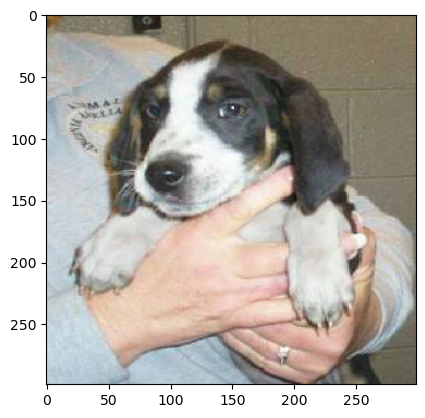

In [7]:
plt.imshow(images["dog"])

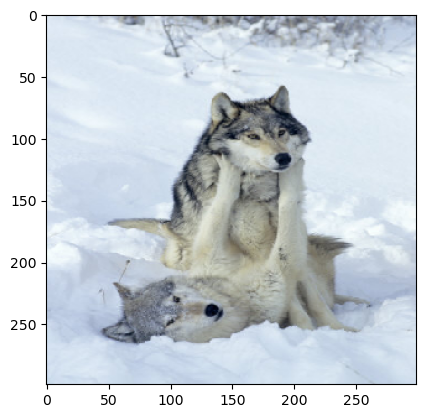

In [8]:
plt.imshow(images["wolf 1"])

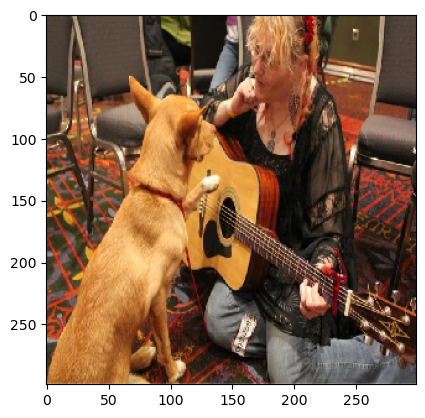

In [9]:
plt.imshow(images["dog guitar"])

Here we call the model on these images and obtain a classification including how confident the network is in its prediction.

In [10]:
predictions = inception_model.predict(
    numpy.array(list(images.values()))
)


2022-11-17 09:33:10.459369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 622ms/step


In [11]:
from tensorflow.keras.applications import imagenet_utils

In [12]:
decoded_predictions = imagenet_utils.decode_predictions(predictions)

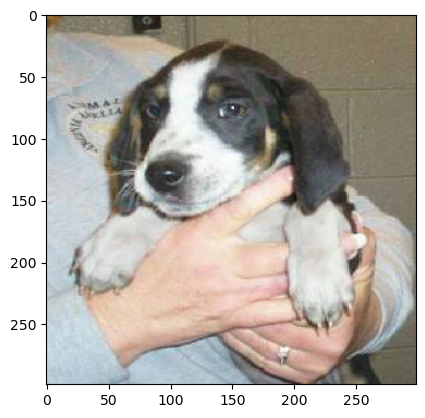

In [13]:
plt.imshow(images["dog"])

<AxesSubplot: xlabel='label'>

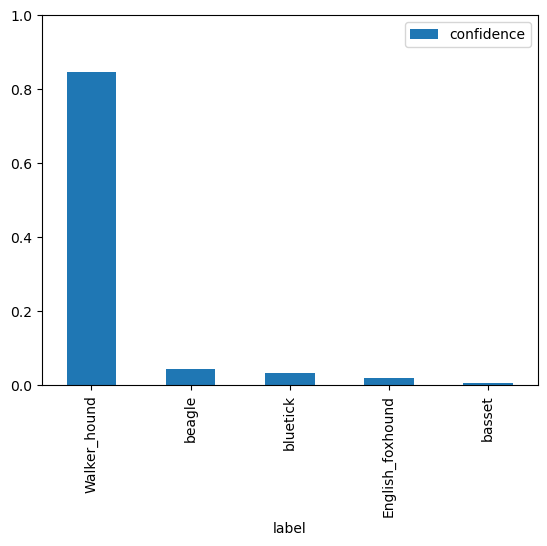

In [14]:
pandas.DataFrame(
    decoded_predictions[0], 
    columns=["class", "label", "confidence"]
).set_index("label").plot(kind="bar", ylim=(0,1))

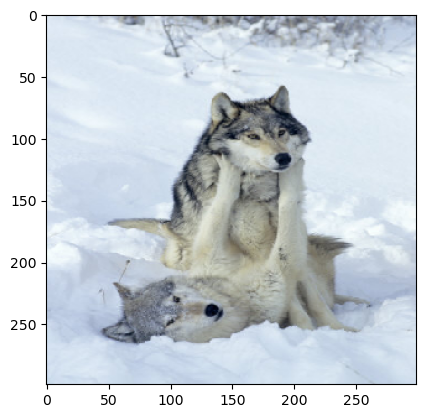

In [15]:
plt.imshow(images["wolf 1"])

<AxesSubplot: xlabel='label'>

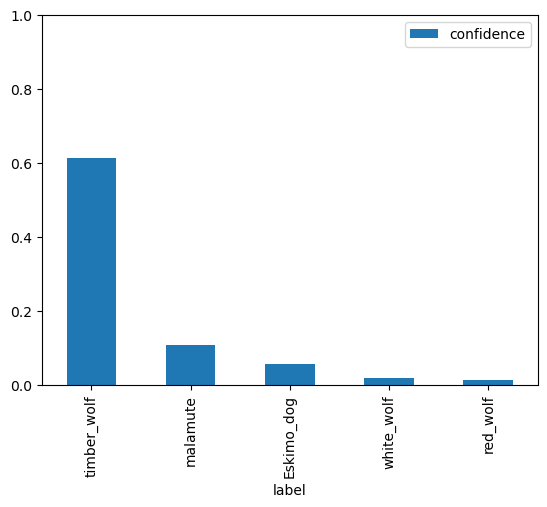

In [16]:
pandas.DataFrame(
    decoded_predictions[1], 
    columns=["class", "label", "confidence"]
).set_index("label").plot(kind="bar", ylim=(0,1))

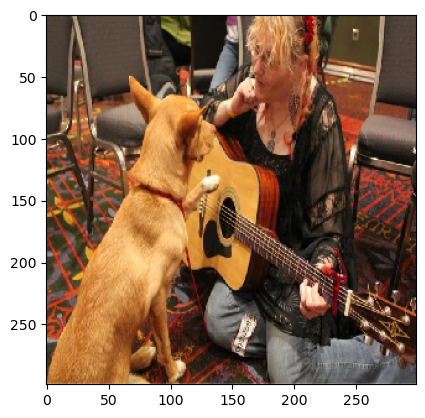

In [17]:
plt.imshow(images["dog guitar"])

<AxesSubplot: xlabel='label'>

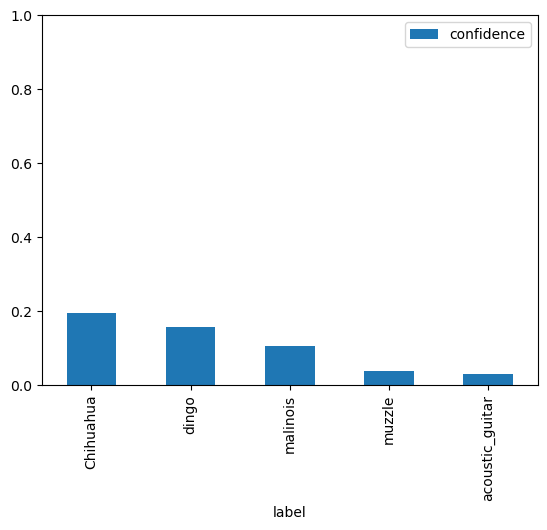

In [18]:
pandas.DataFrame(
    decoded_predictions[2], 
    columns=["class", "label", "confidence"]
).set_index("label").plot(kind="bar", ylim=(0,1))

## Explaining Image Classification with LIME

[**LIME**](https://github.com/marcotcr/lime) is an algorithm library that aims to explain the answers of any classifier, including but not limited to neural networks. LIME includes tools specific for image classification.

In [19]:
import lime

In [20]:
from lime.lime_image import LimeImageExplainer

/Users/cls/miniforge3/envs/ai-training/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
explainer = LimeImageExplainer()

Explaining an instance is rather compute-intensive since it in turn involves estimating a machine learning model:

In [22]:
explanation = explainer.explain_instance(
    images["dog"].astype("double"),
    inception_model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=500
)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 416ms/step


  2%|▏         | 10/500 [00:00<00:23, 20.43it/s]

1/1 [==============================] - 0s 399ms/step


  4%|▍         | 20/500 [00:00<00:22, 21.50it/s]

1/1 [==============================] - 0s 399ms/step


  6%|▌         | 30/500 [00:01<00:21, 21.88it/s]

1/1 [==============================] - 0s 428ms/step


  8%|▊         | 40/500 [00:01<00:21, 21.53it/s]

1/1 [==============================] - 0s 393ms/step


 10%|█         | 50/500 [00:02<00:20, 21.93it/s]

1/1 [==============================] - 0s 386ms/step


 12%|█▏        | 60/500 [00:02<00:19, 22.32it/s]

1/1 [==============================] - 0s 387ms/step


 14%|█▍        | 70/500 [00:03<00:19, 22.54it/s]

1/1 [==============================] - 0s 388ms/step


 16%|█▌        | 80/500 [00:03<00:18, 22.68it/s]

1/1 [==============================] - 0s 391ms/step


 18%|█▊        | 90/500 [00:04<00:18, 22.68it/s]

1/1 [==============================] - 0s 388ms/step


 20%|██        | 100/500 [00:04<00:17, 22.79it/s]

1/1 [==============================] - 0s 390ms/step


 22%|██▏       | 110/500 [00:04<00:17, 22.86it/s]

1/1 [==============================] - 0s 394ms/step


 24%|██▍       | 120/500 [00:05<00:16, 22.82it/s]

1/1 [==============================] - 0s 389ms/step


 26%|██▌       | 130/500 [00:05<00:16, 22.86it/s]

1/1 [==============================] - 0s 390ms/step


 28%|██▊       | 140/500 [00:06<00:15, 22.90it/s]

1/1 [==============================] - 0s 392ms/step


 30%|███       | 150/500 [00:06<00:15, 22.88it/s]

1/1 [==============================] - 0s 400ms/step


 32%|███▏      | 160/500 [00:07<00:14, 22.68it/s]

1/1 [==============================] - 0s 421ms/step


 34%|███▍      | 170/500 [00:07<00:14, 22.27it/s]

1/1 [==============================] - 0s 395ms/step


 36%|███▌      | 180/500 [00:08<00:14, 22.28it/s]

1/1 [==============================] - 0s 394ms/step


 38%|███▊      | 190/500 [00:08<00:13, 22.42it/s]

1/1 [==============================] - 0s 395ms/step


 40%|████      | 200/500 [00:08<00:13, 22.51it/s]

1/1 [==============================] - 0s 397ms/step


 42%|████▏     | 210/500 [00:09<00:12, 22.49it/s]

1/1 [==============================] - 0s 392ms/step


 44%|████▍     | 220/500 [00:09<00:12, 22.56it/s]

1/1 [==============================] - 0s 396ms/step


 46%|████▌     | 230/500 [00:10<00:11, 22.56it/s]

1/1 [==============================] - 0s 401ms/step


 48%|████▊     | 240/500 [00:10<00:11, 22.52it/s]

1/1 [==============================] - 0s 397ms/step


 50%|█████     | 250/500 [00:11<00:11, 22.48it/s]

1/1 [==============================] - 0s 403ms/step


 52%|█████▏    | 260/500 [00:11<00:10, 22.40it/s]

1/1 [==============================] - 0s 405ms/step


 54%|█████▍    | 270/500 [00:12<00:10, 22.29it/s]

1/1 [==============================] - 0s 398ms/step


 56%|█████▌    | 280/500 [00:12<00:09, 22.29it/s]

1/1 [==============================] - 0s 401ms/step


 58%|█████▊    | 290/500 [00:12<00:09, 22.29it/s]

1/1 [==============================] - 0s 397ms/step


 60%|██████    | 300/500 [00:13<00:08, 22.37it/s]

1/1 [==============================] - 0s 404ms/step


 62%|██████▏   | 310/500 [00:13<00:08, 22.35it/s]

1/1 [==============================] - 0s 412ms/step


 64%|██████▍   | 320/500 [00:14<00:08, 22.21it/s]

1/1 [==============================] - 0s 405ms/step


 66%|██████▌   | 330/500 [00:14<00:07, 22.17it/s]

1/1 [==============================] - 0s 409ms/step


 68%|██████▊   | 340/500 [00:15<00:07, 22.09it/s]

1/1 [==============================] - 0s 410ms/step


 70%|███████   | 350/500 [00:15<00:06, 22.01it/s]

1/1 [==============================] - 0s 412ms/step


 72%|███████▏  | 360/500 [00:16<00:06, 21.88it/s]

1/1 [==============================] - 0s 405ms/step


 74%|███████▍  | 370/500 [00:16<00:05, 21.96it/s]

1/1 [==============================] - 0s 414ms/step


 76%|███████▌  | 380/500 [00:17<00:05, 21.86it/s]

1/1 [==============================] - 0s 408ms/step


 78%|███████▊  | 390/500 [00:17<00:05, 21.89it/s]

1/1 [==============================] - 0s 403ms/step


 80%|████████  | 400/500 [00:17<00:04, 22.02it/s]

1/1 [==============================] - 0s 406ms/step


 82%|████████▏ | 410/500 [00:18<00:04, 22.02it/s]

1/1 [==============================] - 0s 407ms/step


 84%|████████▍ | 420/500 [00:18<00:03, 22.03it/s]

1/1 [==============================] - 0s 413ms/step


 86%|████████▌ | 430/500 [00:19<00:03, 21.95it/s]

1/1 [==============================] - 0s 413ms/step


 88%|████████▊ | 440/500 [00:19<00:02, 21.91it/s]

1/1 [==============================] - 0s 414ms/step


 90%|█████████ | 450/500 [00:20<00:02, 21.76it/s]

1/1 [==============================] - 0s 411ms/step


 92%|█████████▏| 460/500 [00:20<00:01, 21.79it/s]

1/1 [==============================] - 0s 414ms/step


 94%|█████████▍| 470/500 [00:21<00:01, 21.73it/s]

1/1 [==============================] - 0s 416ms/step


 96%|█████████▌| 480/500 [00:21<00:00, 21.69it/s]

1/1 [==============================] - 0s 418ms/step


 98%|█████████▊| 490/500 [00:22<00:00, 21.66it/s]

1/1 [==============================] - 0s 414ms/step


100%|██████████| 500/500 [00:22<00:00, 22.20it/s]


In [23]:
from skimage.segmentation import mark_boundaries

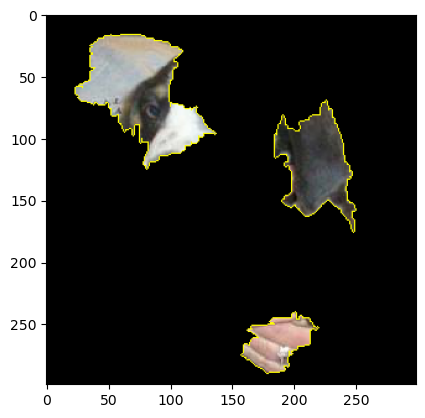

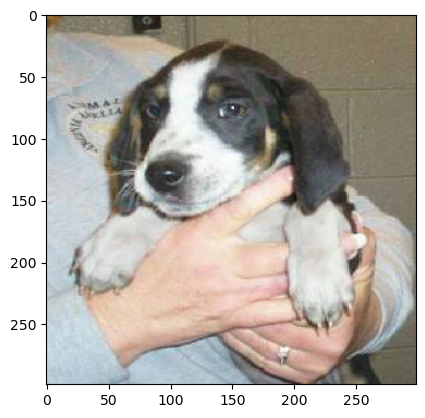

In [24]:
explained_image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
plt.figure()
plt.imshow(mark_boundaries(explained_image, mask))
plt.figure()
plt.imshow(images["dog"])

It's the ears!

> The skull should be broad, with a long muzzle and **long, hanging ears**.

-- [Wikipedia: Treeing Walker Coonhound](https://en.m.wikipedia.org/wiki/Treeing_Walker_Coonhound)

In [25]:
explanation = explainer.explain_instance(
    images["wolf 1"].astype("double"), 
    inception_model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=500
)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 420ms/step


  2%|▏         | 10/500 [00:00<00:22, 21.32it/s]

1/1 [==============================] - 0s 419ms/step


  4%|▍         | 20/500 [00:00<00:22, 21.44it/s]

1/1 [==============================] - 0s 425ms/step


  6%|▌         | 30/500 [00:01<00:22, 21.24it/s]

1/1 [==============================] - 0s 443ms/step


  8%|▊         | 40/500 [00:01<00:22, 20.87it/s]

1/1 [==============================] - 0s 424ms/step


 10%|█         | 50/500 [00:02<00:21, 20.99it/s]

1/1 [==============================] - 0s 422ms/step


 12%|█▏        | 60/500 [00:02<00:20, 21.07it/s]

1/1 [==============================] - 0s 421ms/step


 14%|█▍        | 70/500 [00:03<00:20, 21.10it/s]

1/1 [==============================] - 0s 424ms/step


 16%|█▌        | 80/500 [00:03<00:19, 21.13it/s]

1/1 [==============================] - 0s 427ms/step


 18%|█▊        | 90/500 [00:04<00:19, 21.10it/s]

1/1 [==============================] - 0s 427ms/step


 20%|██        | 100/500 [00:04<00:18, 21.08it/s]

1/1 [==============================] - 0s 429ms/step


 22%|██▏       | 110/500 [00:05<00:18, 21.03it/s]

1/1 [==============================] - 0s 427ms/step


 24%|██▍       | 120/500 [00:05<00:18, 21.04it/s]

1/1 [==============================] - 0s 425ms/step


 26%|██▌       | 130/500 [00:06<00:17, 21.07it/s]

1/1 [==============================] - 0s 425ms/step


 28%|██▊       | 140/500 [00:06<00:17, 21.00it/s]

1/1 [==============================] - 0s 425ms/step


 30%|███       | 150/500 [00:07<00:16, 21.05it/s]

1/1 [==============================] - 0s 428ms/step


 32%|███▏      | 160/500 [00:07<00:16, 21.01it/s]

1/1 [==============================] - 0s 433ms/step


 34%|███▍      | 170/500 [00:08<00:15, 20.92it/s]

1/1 [==============================] - 0s 430ms/step


 36%|███▌      | 180/500 [00:08<00:15, 20.92it/s]

1/1 [==============================] - 0s 429ms/step


 38%|███▊      | 190/500 [00:09<00:14, 20.92it/s]

1/1 [==============================] - 0s 432ms/step


 40%|████      | 200/500 [00:09<00:14, 20.86it/s]

1/1 [==============================] - 0s 439ms/step


 42%|████▏     | 210/500 [00:10<00:13, 20.73it/s]

1/1 [==============================] - 0s 435ms/step


 44%|████▍     | 220/500 [00:10<00:13, 20.69it/s]

1/1 [==============================] - 0s 446ms/step


 46%|████▌     | 230/500 [00:10<00:13, 20.48it/s]

1/1 [==============================] - 0s 438ms/step


 48%|████▊     | 240/500 [00:11<00:12, 20.48it/s]

1/1 [==============================] - 0s 437ms/step


 50%|█████     | 250/500 [00:11<00:12, 20.52it/s]

1/1 [==============================] - 0s 461ms/step


 52%|█████▏    | 260/500 [00:12<00:11, 20.23it/s]

1/1 [==============================] - 0s 467ms/step


 54%|█████▍    | 270/500 [00:12<00:11, 19.96it/s]

1/1 [==============================] - 0s 465ms/step


 56%|█████▌    | 280/500 [00:13<00:11, 19.72it/s]

1/1 [==============================] - 1s 509ms/step


 58%|█████▊    | 290/500 [00:14<00:10, 19.12it/s]

1/1 [==============================] - 0s 473ms/step


 60%|██████    | 300/500 [00:14<00:10, 19.05it/s]

1/1 [==============================] - 1s 615ms/step


 62%|██████▏   | 310/500 [00:15<00:10, 17.57it/s]

1/1 [==============================] - 1s 505ms/step


 64%|██████▍   | 320/500 [00:15<00:10, 17.67it/s]

1/1 [==============================] - 1s 545ms/step


 66%|██████▌   | 330/500 [00:16<00:09, 17.29it/s]

1/1 [==============================] - 0s 485ms/step


 68%|██████▊   | 340/500 [00:16<00:09, 17.67it/s]

1/1 [==============================] - 1s 522ms/step


 70%|███████   | 350/500 [00:17<00:08, 17.59it/s]

1/1 [==============================] - 1s 523ms/step


 72%|███████▏  | 360/500 [00:18<00:07, 17.52it/s]

1/1 [==============================] - 0s 461ms/step


 74%|███████▍  | 370/500 [00:18<00:07, 18.03it/s]

1/1 [==============================] - 1s 542ms/step


 76%|███████▌  | 380/500 [00:19<00:06, 17.63it/s]

1/1 [==============================] - 1s 537ms/step


 78%|███████▊  | 390/500 [00:19<00:06, 17.44it/s]

1/1 [==============================] - 1s 539ms/step


 80%|████████  | 400/500 [00:20<00:05, 17.21it/s]

1/1 [==============================] - 0s 462ms/step


 82%|████████▏ | 410/500 [00:20<00:05, 17.83it/s]

1/1 [==============================] - 0s 480ms/step


 84%|████████▍ | 420/500 [00:21<00:04, 18.01it/s]

1/1 [==============================] - 0s 453ms/step


 86%|████████▌ | 430/500 [00:21<00:03, 18.53it/s]

1/1 [==============================] - 0s 478ms/step


 88%|████████▊ | 440/500 [00:22<00:03, 18.65it/s]

1/1 [==============================] - 0s 493ms/step


 90%|█████████ | 450/500 [00:23<00:02, 18.57it/s]

1/1 [==============================] - 1s 512ms/step


 92%|█████████▏| 460/500 [00:23<00:02, 18.25it/s]

1/1 [==============================] - 0s 493ms/step


 94%|█████████▍| 470/500 [00:24<00:01, 18.25it/s]

1/1 [==============================] - 0s 482ms/step


 96%|█████████▌| 480/500 [00:24<00:01, 18.35it/s]

1/1 [==============================] - 0s 493ms/step


 98%|█████████▊| 490/500 [00:25<00:00, 18.31it/s]

1/1 [==============================] - 0s 490ms/step


100%|██████████| 500/500 [00:25<00:00, 19.37it/s]


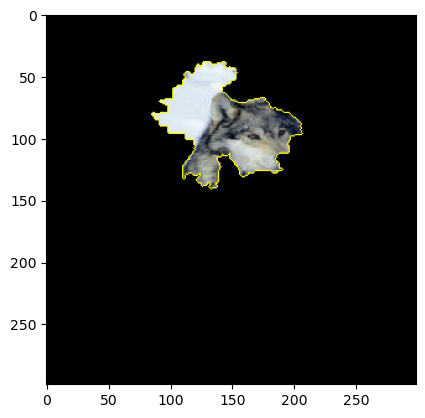

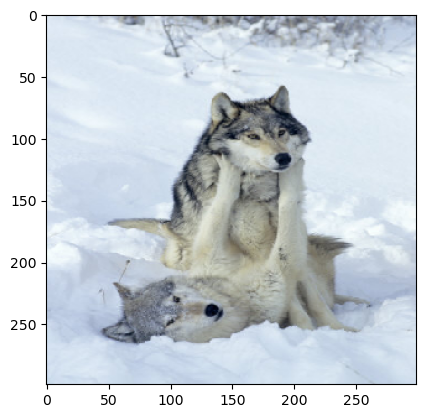

In [26]:
explained_image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
plt.figure()
plt.imshow(mark_boundaries(explained_image, mask))
plt.figure()
plt.imshow(images["wolf 1"])

In the case of the last photo, there were multiple objects detected. We can use the explainer to segment the image into the parts that provide support for each of the classes. Let's look at the classes "chihuahua" and "acoustic guitar".

In [27]:
explanation = explainer.explain_instance(
    images["dog guitar"].astype("double"), 
    inception_model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=500
)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 496ms/step


  2%|▏         | 10/500 [00:00<00:26, 18.37it/s]

1/1 [==============================] - 1s 510ms/step


  4%|▍         | 20/500 [00:01<00:26, 17.93it/s]

1/1 [==============================] - 1s 527ms/step


  6%|▌         | 30/500 [00:01<00:26, 17.58it/s]

1/1 [==============================] - 0s 470ms/step


  8%|▊         | 40/500 [00:02<00:25, 17.99it/s]

1/1 [==============================] - 0s 461ms/step


 10%|█         | 50/500 [00:02<00:24, 18.42it/s]

1/1 [==============================] - 0s 484ms/step


 12%|█▏        | 60/500 [00:03<00:23, 18.50it/s]

1/1 [==============================] - 0s 462ms/step


 14%|█▍        | 70/500 [00:03<00:22, 18.81it/s]

1/1 [==============================] - 1s 511ms/step


 16%|█▌        | 80/500 [00:04<00:22, 18.46it/s]

1/1 [==============================] - 1s 519ms/step


 18%|█▊        | 90/500 [00:04<00:22, 18.14it/s]

1/1 [==============================] - 0s 489ms/step


 20%|██        | 100/500 [00:05<00:21, 18.23it/s]

1/1 [==============================] - 0s 461ms/step


 22%|██▏       | 110/500 [00:05<00:20, 18.58it/s]

1/1 [==============================] - 0s 472ms/step


 24%|██▍       | 120/500 [00:06<00:20, 18.67it/s]

1/1 [==============================] - 0s 467ms/step


 26%|██▌       | 130/500 [00:07<00:19, 18.81it/s]

1/1 [==============================] - 0s 489ms/step


 28%|██▊       | 140/500 [00:07<00:19, 18.70it/s]

1/1 [==============================] - 0s 481ms/step


 30%|███       | 150/500 [00:08<00:18, 18.71it/s]

1/1 [==============================] - 0s 459ms/step


 32%|███▏      | 160/500 [00:08<00:17, 18.94it/s]

1/1 [==============================] - 0s 476ms/step


 34%|███▍      | 170/500 [00:09<00:17, 18.90it/s]

1/1 [==============================] - 0s 480ms/step


 36%|███▌      | 180/500 [00:09<00:16, 18.83it/s]

1/1 [==============================] - 0s 462ms/step


 38%|███▊      | 190/500 [00:10<00:16, 18.96it/s]

1/1 [==============================] - 0s 458ms/step


 40%|████      | 200/500 [00:10<00:15, 19.17it/s]

1/1 [==============================] - 0s 462ms/step


 42%|████▏     | 210/500 [00:11<00:15, 19.20it/s]

1/1 [==============================] - 0s 464ms/step


 44%|████▍     | 220/500 [00:11<00:14, 19.26it/s]

1/1 [==============================] - 0s 458ms/step


 46%|████▌     | 230/500 [00:12<00:13, 19.34it/s]

1/1 [==============================] - 0s 457ms/step


 48%|████▊     | 240/500 [00:12<00:13, 19.43it/s]

1/1 [==============================] - 0s 467ms/step


 50%|█████     | 250/500 [00:13<00:12, 19.33it/s]

1/1 [==============================] - 0s 457ms/step


 52%|█████▏    | 260/500 [00:13<00:12, 19.38it/s]

1/1 [==============================] - 0s 463ms/step


 54%|█████▍    | 270/500 [00:14<00:11, 19.39it/s]

1/1 [==============================] - 0s 466ms/step


 56%|█████▌    | 280/500 [00:14<00:11, 19.33it/s]

1/1 [==============================] - 0s 455ms/step


 58%|█████▊    | 290/500 [00:15<00:10, 19.46it/s]

1/1 [==============================] - 0s 465ms/step


 60%|██████    | 300/500 [00:15<00:10, 19.42it/s]

1/1 [==============================] - 0s 463ms/step


 62%|██████▏   | 310/500 [00:16<00:09, 19.31it/s]

1/1 [==============================] - 0s 491ms/step


 64%|██████▍   | 320/500 [00:16<00:09, 19.02it/s]

1/1 [==============================] - 0s 453ms/step


 66%|██████▌   | 330/500 [00:17<00:08, 19.25it/s]

1/1 [==============================] - 0s 461ms/step


 68%|██████▊   | 340/500 [00:17<00:08, 19.30it/s]

1/1 [==============================] - 0s 458ms/step


 70%|███████   | 350/500 [00:18<00:07, 19.42it/s]

1/1 [==============================] - 0s 495ms/step


 72%|███████▏  | 360/500 [00:19<00:07, 19.02it/s]

1/1 [==============================] - 0s 464ms/step


 74%|███████▍  | 370/500 [00:19<00:06, 19.11it/s]

1/1 [==============================] - 0s 468ms/step


 76%|███████▌  | 380/500 [00:20<00:06, 19.13it/s]

1/1 [==============================] - 0s 476ms/step


 78%|███████▊  | 390/500 [00:20<00:05, 19.05it/s]

1/1 [==============================] - 0s 478ms/step


 80%|████████  | 400/500 [00:21<00:05, 18.92it/s]

1/1 [==============================] - 0s 479ms/step


 82%|████████▏ | 410/500 [00:21<00:04, 18.87it/s]

1/1 [==============================] - 1s 517ms/step


 84%|████████▍ | 420/500 [00:22<00:04, 18.43it/s]

1/1 [==============================] - 0s 494ms/step


 86%|████████▌ | 430/500 [00:22<00:03, 18.35it/s]

1/1 [==============================] - 0s 484ms/step


 88%|████████▊ | 440/500 [00:23<00:03, 18.42it/s]

1/1 [==============================] - 0s 487ms/step


 90%|█████████ | 450/500 [00:23<00:02, 18.41it/s]

1/1 [==============================] - 1s 527ms/step


 92%|█████████▏| 460/500 [00:24<00:02, 18.03it/s]

1/1 [==============================] - 0s 471ms/step


 94%|█████████▍| 470/500 [00:24<00:01, 18.29it/s]

1/1 [==============================] - 0s 480ms/step


 96%|█████████▌| 480/500 [00:25<00:01, 18.43it/s]

1/1 [==============================] - 1s 502ms/step


 98%|█████████▊| 490/500 [00:26<00:00, 18.27it/s]

1/1 [==============================] - 1s 502ms/step


100%|██████████| 500/500 [00:26<00:00, 18.77it/s]


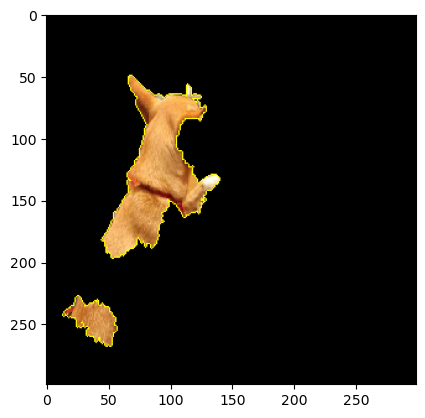

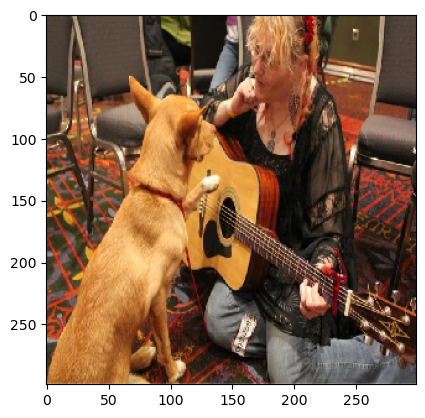

In [28]:
explained_image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
plt.figure()
plt.imshow(mark_boundaries(explained_image, mask))
plt.figure()
plt.imshow(images["dog guitar"])

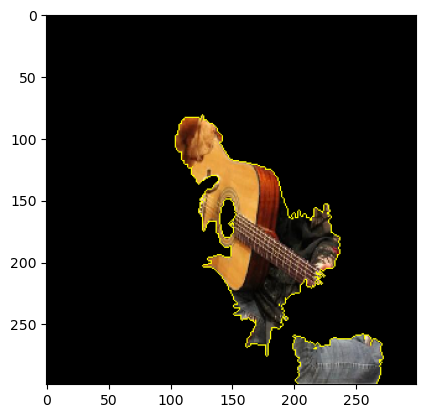

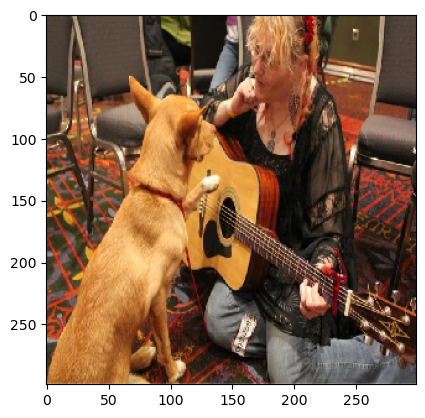

In [29]:
explained_image, mask = explanation.get_image_and_mask(
    explanation.top_labels[4], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
plt.figure()
plt.imshow(mark_boundaries(explained_image, mask))
plt.figure()
plt.imshow(images["dog guitar"])

## References

- [Local Interpretable Model-Agnostic Explanations (LIME): An Introduction](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime)
- [Ribeiro et al.: _“Why Should I Trust You?”
Explaining the Predictions of Any Classifier_](https://arxiv.org/pdf/1602.04938.pdf)
- [Lapuschkin et al. : _Unmasking Clever Hans predictors and assessing
what machines really learn_](https://www.nature.com/articles/s41467-019-08987-4.pdf)
- [Vincent Warmerdam: How to Constrain Artificial Stupidity | PyData London 2019](https://www.youtube.com/watch?v=Z8MEFI7ZJlA)

---
_This notebook is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/). Copyright © 2018-2021 [Point 8 GmbH](https://point-8.de)_